In [1]:
import massbalancemachine as mbm
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

In [2]:
df = pd.read_csv('./example_data/iceland/files/iceland_monthly_dataset.csv')
df.dropna(axis=0, how='any', inplace=True)

In [11]:
from sklearn.exceptions import NotFittedError
from sklearn.base import BaseEstimator

class Model(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y, **fit_params):
        pass
    
    def predict(self, features):
        pass
    
    def score(self, X, y):
        pass

class CustomXGBoostRegressor(Model, XGBRegressor):
    def __init__(self, random_state=None, **kwargs):
        Model.__init__(self)
        XGBRegressor.__init__(self, random_state=random_state, **kwargs)
        self.is_fitted_ = False

    def fit(self, X, y, **fit_params):
        """
        Fit the model to the training data.

        This method overrides the parent class fit method to incorporate
        a custom objective function that uses metadata.

        Args:
            **kwargs:
            X (pd.DataFrame): The input features including metadata columns.
            y (array-like): The target values.
            **fit_params: Additional parameters to be passed to the parent fit method.

        Returns:
            self: The fitted estimator.
        """

        # Separate the features from the metadata provided in the dataset
        features, metadata = self._create_features_metadata(X)

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return self._custom_mse_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        print("Calling XGBRegressor fit method")
        super(XGBRegressor, self).fit(features, y, **fit_params)
        self.is_fitted_ = True
        print("Fit method completed")

        return self
    
    
    def predict(self, features):
        """
        Predict using the fitted model.

        Args:
            features (pd.DataFrame): The input features.

        Returns:
            array-like: The predicted values.
        """
        print("Starting predict method")
        if not self.is_fitted_:
            raise NotFittedError("This CustomXGBoostRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.")
        # Check if the model is fitted
        check_is_fitted(self)

        return super(XGBRegressor, self).predict(features)
    
    def score(self, X, y):
        """
        Compute the mean squared error of the model on the given test data and labels.

        Args:
            X (pd.DataFrame): The input features including metadata columns.
            y (array-like): The true labels.

        Returns:
            float: The negative mean squared error (for compatibility with sklearn's GridSearchCV).
        """

        # Separate the features from the metadata provided in the dataset
        features, metadata = self._create_features_metadata(X)

        # Make a prediction based on the features available in the dataset
        y_pred = self.predict(features)

        # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
        # based on the metadata.
        y_pred_agg, y_true_mean, _, _ = self._create_metadata_scores(metadata, y, y_pred)

        # Calculate MSE
        mse = ((y_pred_agg - y_true_mean) ** 2).mean()

        return -mse  # Return negative because GridSearchCV maximizes score
    
    
    def get_params(self, deep=True):
        params = super(XGBRegressor, self).get_params(deep=deep)
        params.update(XGBRegressor.get_params(self, deep=deep))
        return params

    def set_params(self, **params):
        super(XGBRegressor, self).set_params(**params)
        return self
    

    @staticmethod
    def _create_features_metadata(X):
        """
        Split the input DataFrame into features and metadata.

        Args:
            X (pd.DataFrame): The input DataFrame containing both features and metadata.

        Returns:
            tuple: A tuple containing:
                - features (array-like): The feature values.
                - metadata (array-like): The metadata values.
        """
        # Split features from metadata
        metadata_columns = ['POINT_ID', 'ID', 'N_MONTHS']
        # Get feature columns by subtracting metadata columns from all columns
        feature_columns = X.columns.difference(metadata_columns)

        # Convert feature_columns to a list (if needed)
        feature_columns = list(feature_columns)

        # Extract metadata and features
        metadata = X[metadata_columns[1:]].values  # Exclude 'POINT_ID'
        features = X[feature_columns].values

        return features, metadata

    @staticmethod
    def _custom_mse_metadata(y_true, y_pred, metadata):
        """
        Compute custom gradients and hessians for the MSE loss, taking into account metadata.

        Args:
            y_true (array-like): The true target values.
            y_pred (array-like): The predicted values.
            metadata (array-like): The metadata for each data point.

        Returns:
            tuple: A tuple containing:
                - gradients (array-like): The computed gradients.
                - hessians (array-like): The computed hessians.
        """
        # Initialize gradients and hessians
        gradients = np.zeros_like(y_pred)
        hessians = np.ones_like(y_pred)

        # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
        # based on the metadata.
        y_pred_agg, y_true_mean, grouped_ids, df_metadata = CustomXGBoostRegressor._create_metadata_scores(metadata, y_true, y_pred)

        # Compute gradients
        gradients_agg = y_pred_agg - y_true_mean

        # Create a mapping from ID to gradient
        gradient_map = dict(zip(grouped_ids.groups.keys(), gradients_agg))

        # Assign gradients to corresponding indices
        df_metadata['gradient'] = df_metadata['ID'].map(gradient_map)
        gradients[df_metadata.index] = df_metadata['gradient'].values

        return gradients, hessians

    @staticmethod
    def _create_metadata_scores(metadata, y1, y2):
        """
        Create aggregated scores based on metadata.

        Args:
            metadata (array-like): The metadata for each data point.
            y1 (array-like): The first set of values (typically true values).
            y2 (array-like): The second set of values (typically predicted values).

        Returns:
            tuple: A tuple containing:
                - y_pred_agg (array-like): Aggregated predictions.
                - y_true_mean (array-like): Mean of true values.
                - grouped_ids (pd.GroupBy): Grouped data by ID.
                - df_metadata (pd.DataFrame): DataFrame of metadata.
        """
        df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS'])

        # Aggregate y_pred and y_true for each group
        grouped_ids = df_metadata.assign(y_true=y1, y_pred=y2).groupby('ID')
        y_pred_agg = grouped_ids['y_pred'].sum().values
        y_true_mean = grouped_ids['y_true'].mean().values

        return y_pred_agg, y_true_mean, grouped_ids, df_metadata


In [ ]:
dl = mbm.DataLoader(data=df)
train_itr, test_itr = dl.set_train_test_split()
splits = dl.get_cv_split()

In [4]:
base_estimator = CustomXGBoostRegressor()

In [ ]:
parameters = {
    'max_depth': [3, 4, 5, ],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'gamma': [0, 1]
}

clf = GridSearchCV(
    estimator=base_estimator,
    param_grid=parameters,
    cv=splits,
    verbose=10,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    error_score='raise'
)

train_indices, test_indices = list(train_itr), list(test_itr)

df_X = df.iloc[train_indices]
y = df_X['POINT_BALANCE'].values
# Fit using features
clf.fit(df_X, y)

In [ ]:
y

In [ ]:
len(y)

In [ ]:
df_X

In [5]:
df = pd.read_csv('./example_data/iceland/files/iceland_monthly_dataset.csv')
df.dropna(axis=0, how='any', inplace=True)
dataset = df
import sklearn

In [6]:
metadata_columns = ['POINT_ID', 'ID', 'N_MONTHS']
# Get feature columns by subtracting metadata columns from all columns
feature_columns = dataset.columns.difference(metadata_columns)

# Convert feature_columns to a list (if needed)
feature_columns = list(feature_columns)

# Extract metadata and features
metadata = dataset[metadata_columns[1:]].values  # Exclude 'POINT_ID'
df_X_train = dataset[feature_columns]

# Select the targets for training
df_y_train = dataset[['POINT_BALANCE']]

# Get arrays of features+metadata and targets
X_train, y_train = df_X_train.values, df_y_train.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
glacier_ids = np.array(dataset['ID'].values)

# Use five folds
group_kf_s = sklearn.model_selection.GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits = list(group_kf_s.split(X_train, y_train, glacier_ids))

In [7]:
df_X_train

,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,MONTHS,POINT_BALANCE,POINT_LAT,POINT_LON,RGIId,YEAR,aspect,fal,slhf,slope,sshf,ssrd,str,t2m,tp
0,1333.923612,-116.476388,oct,2.07,64.885013,-18.773871,RGI60-06.00228,1995,1.606406,0.850005,-32688.346894,0.056246,1.908546e+05,3.434260e+06,-1.029337e+06,267.885682,0.005071
1,1333.923612,-116.476388,nov,2.07,64.885013,-18.773871,RGI60-06.00228,1995,1.606406,0.849992,301104.083653,0.056246,8.280538e+05,8.424995e+05,-1.431540e+06,266.376346,0.006053
2,1333.923612,-116.476388,dec,2.07,64.885013,-18.773871,RGI60-06.00228,1995,1.606406,0.849992,248241.745197,0.056246,9.954409e+05,1.322171e+05,-2.002829e+06,263.049011,0.005854
3,1333.923612,-116.476388,jan,2.07,64.885013,-18.773871,RGI60-06.00228,1995,1.606406,0.849992,348585.225978,0.056246,1.243700e+06,4.884578e+05,-1.792889e+06,261.692810,0.004156
4,1333.923612,-116.476388,feb,2.07,64.885013,-18.773871,RGI60-06.00228,1995,1.606406,0.850005,274514.643950,0.056246,1.004845e+06,2.580602e+06,-1.861757e+06,261.140088,0.002287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,1067.593874,246.593874,jun,-2.63,64.662707,-18.954942,RGI60-06.00232,2018,2.889730,0.768536,10994.304045,0.018996,6.234279e+05,1.787212e+07,-9.177811e+05,276.144439,0.003192
454,1067.593874,246.593874,jul,-2.63,64.662707,-18.954942,RGI60-06.00232,2018,2.889730,0.676787,-589325.605420,0.018996,7.537638e+04,1.425122e+07,-7.246837e+05,277.553280,0.003422
455,1067.593874,246.593874,aug,-2.63,64.662707,-18.954942,RGI60-06.00232,2018,2.889730,0.677706,-807105.778219,0.018996,-1.563324e+05,1.332676e+07,-1.884936e+06,276.193729,0.002495
456,1067.593874,246.593874,sep,-2.63,64.662707,-18.954942,RGI60-06.00232,2018,2.889730,0.717923,-432479.565272,0.018996,1.434597e+05,9.078256e+06,-2.152404e+06,273.151130,0.003491


In [9]:
len(y_train)

447

In [27]:
from sklearn.model_selection import GridSearchCV, KFold

parameters = {
    'max_depth': [3, 4, 5, 6, 7],#, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],#, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'gamma':[0, 1]#, 1, 10],
    }

base_estimator = CustomXGBoostRegressor(random_state=42)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

clf = GridSearchCV(
    estimator=base_estimator,
    param_grid=parameters,
    cv=cv,
    verbose=2,
    scoring = None,
    n_jobs=-1,  # Set to 1 for easier debugging
    error_score='raise',
    return_train_score=True
)

df_train_X_reduce = dataset.drop(['POINT_BALANCE', 'POINT_ID', 'MONTHS', 'RGIId'], axis=1)

# Fit using features
print("Starting GridSearchCV fit")
clf.fit(df_train_X_reduce, dataset['POINT_BALANCE'].values)
print("GridSearchCV fit completed")

Starting GridSearchCV fit
Fitting 3 folds for each of 160 candidates, totalling 480 fits


C:\Users\Jbies\anaconda3\envs\mbmenv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Calling XGBRegressor fit method
Fit method completed
GridSearchCV fit completed


In [28]:
clf.cv_results_

{'mean_fit_time': array([5.20391059, 6.6753304 , 8.1275123 , 8.76149289, 1.52322745,
        3.20069655, 4.44558088, 5.82399853, 1.90133278, 2.88366628,
        4.22533679, 5.91266672, 1.95333234, 2.62899931, 4.43585738,
        5.69319367, 1.2483333 , 3.44385926, 4.7115283 , 7.98033341,
        1.70167255, 3.42300121, 5.49199367, 5.99832718, 1.7916681 ,
        2.67166694, 3.91800634, 5.46366763, 1.63633307, 2.73000042,
        4.29699842, 5.16366466, 1.32533328, 2.84833376, 3.86399857,
        5.51500241, 1.37866497, 2.81600189, 4.35666736, 5.88300101,
        1.56899977, 3.11133957, 4.89887158, 6.6580352 , 2.0428377 ,
        3.67440645, 5.52733588, 7.59486111, 1.73775609, 3.90308015,
        6.29260254, 7.32901549, 2.29528022, 3.68218239, 4.8395745 ,
        6.53139051, 1.67030144, 3.53304513, 5.2408309 , 7.83251754,
        2.02679197, 4.33738963, 6.683086  , 8.45752303, 1.99230266,
        3.77891334, 6.80953948, 9.00499336, 2.73424896, 4.55685043,
        6.95115296, 8.19883672,

In [29]:
clf

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise',
             estimator=CustomXGBoostRegressor(random_state=42), n_jobs=-1,
             param_grid={'gamma': [0, 1],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [100, 200, 300, 400]},
             return_train_score=True, verbose=2)

In [30]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

def plot_gsearch_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    width = len(grid.best_params_.keys())*5

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(width,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
        ax[i].grid()

    plt.legend()
    plt.show()

def plot_feature_permutation_importance(model, X, y, X_labels):

    model.fit(X, y)
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, X_labels[sorted_idx])
    plt.title("Feature Importance (MDI)")

    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=X_labels[sorted_idx],
    )
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()
    

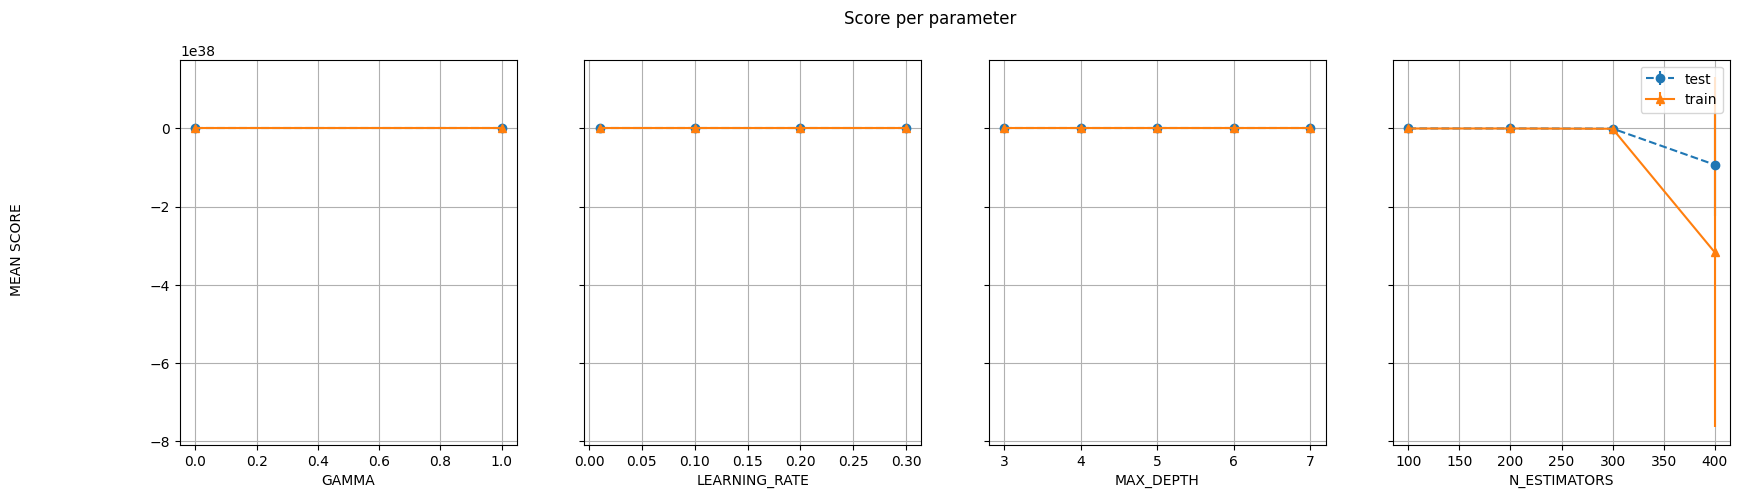

In [31]:
plot_gsearch_results(clf)